## Learning Objectives
- Understand active learning and informative sample selection
- Use LLMs to identify valuable training examples
- Compare different selection strategies
- Evaluate the impact of selected samples on model performance

In [3]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 1. LOAD LLM MODEL (Qwen-2.5-0.5B Instruct)

In [4]:
def load_llm_model(model_name="Qwen/Qwen2.5-0.5B-Instruct"):
    """
    Load Qwen-2.5-0.5B Instruct model for query selection
    This model is small enough to run on Google Colab
    """
    print(f"Loading {model_name}...")
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            device_map="auto" if torch.cuda.is_available() else None
        )
        
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            
        print(f"Model loaded successfully!")
        return tokenizer, model
        
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Falling back to a smaller alternative...")
        # Fallback to a smaller model if needed
        return None, None

# Load the LLM
llm_tokenizer, llm_model = load_llm_model()

Loading Qwen/Qwen2.5-0.5B-Instruct...
Model loaded successfully!


### 2. SAMPLE DATA PREPARATION

In [5]:
import random
import numpy as np
from datasets import load_dataset
from textstat import flesch_reading_ease
import re

def create_diverse_imdb_dataset(n_samples=10000, test_split=False):
    """
    Create a diverse text classification dataset using the actual IMDB dataset
    with varying difficulty levels based on review characteristics
    """
    
    # Load IMDB dataset
    dataset = load_dataset("imdb")
    split = "test" if test_split else "train"
    imdb_data = dataset[split]
    
    texts = []
    labels = []
    difficulty = []
    
    # Process samples from IMDB dataset
    indices = random.sample(range(len(imdb_data)), min(n_samples * 2, len(imdb_data)))
    
    for idx in indices:
        if len(texts) >= n_samples:
            break
            
        text = imdb_data[idx]['text']
        label = imdb_data[idx]['label']  # 0 = negative, 1 = positive
        
        # Clean text (remove HTML tags, extra whitespace)
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Skip very short reviews
        if len(text.split()) < 10:
            continue
            
        # Determine difficulty based on review characteristics
        difficulty_level = classify_difficulty(text, label)
        
        texts.append(text)
        labels.append(label)
        difficulty.append(difficulty_level)
    
    # Ensure we have the requested number of samples
    if len(texts) < n_samples:
        # If we need more samples, cycle through what we have
        while len(texts) < n_samples:
            idx = len(texts) % len(imdb_data)
            text = re.sub(r'<[^>]+>', '', imdb_data[idx]['text'])
            text = re.sub(r'\s+', ' ', text).strip()
            
            if len(text.split()) >= 10:
                texts.append(text)
                labels.append(imdb_data[idx]['label'])
                difficulty.append(classify_difficulty(text, imdb_data[idx]['label']))
    
    # Trim to exact size
    texts = texts[:n_samples]
    labels = labels[:n_samples]
    difficulty = difficulty[:n_samples]
    
    # Shuffle the dataset
    combined = list(zip(texts, labels, difficulty))
    random.shuffle(combined)
    texts, labels, difficulty = zip(*combined)
    
    return list(texts), list(labels), list(difficulty)

def classify_difficulty(text, label):
    """
    Classify the difficulty of a review based on various characteristics
    """
    
    # Word indicators for clear sentiment
    strong_positive = ['amazing', 'fantastic', 'brilliant', 'outstanding', 'perfect', 
                      'excellent', 'wonderful', 'incredible', 'magnificent', 'superb']
    strong_negative = ['terrible', 'awful', 'horrible', 'worst', 'hate', 'disgusting',
                      'pathetic', 'garbage', 'trash', 'atrocious']
    
    # Ambiguity indicators
    mixed_indicators = ['but', 'however', 'although', 'despite', 'nevertheless', 
                       'on the other hand', 'mixed', 'somewhat', 'partially']
    
    text_lower = text.lower()
    
    # Count strong sentiment words
    strong_pos_count = sum(1 for word in strong_positive if word in text_lower)
    strong_neg_count = sum(1 for word in strong_negative if word in text_lower)
    mixed_count = sum(1 for phrase in mixed_indicators if phrase in text_lower)
    
    # Calculate reading complexity
    try:
        reading_ease = flesch_reading_ease(text)
    except:
        reading_ease = 50  # Default middle value
    
    # Length factor
    word_count = len(text.split())
    
    # Determine difficulty
    if label == 1:  # Positive review
        if strong_pos_count >= 2 and mixed_count == 0 and reading_ease > 60:
            return 'easy'
        elif strong_neg_count > 0 or mixed_count >= 2 or reading_ease < 30:
            return 'hard'
        else:
            return 'medium'
    else:  # Negative review
        if strong_neg_count >= 2 and mixed_count == 0 and reading_ease > 60:
            return 'easy'
        elif strong_pos_count > 0 or mixed_count >= 2 or reading_ease < 30:
            return 'hard'
        else:
            return 'medium'

def get_difficulty_distribution(difficulty_list):
    """
    Get the distribution of difficulty levels in the dataset
    """
    from collections import Counter
    return Counter(difficulty_list)

In [6]:
texts, labels, difficulty = create_diverse_imdb_dataset(n_samples=100000)
    
print(f"Dataset created with {len(texts)} samples")
print(f"Label distribution: {sum(labels)} positive, {len(labels) - sum(labels)} negative")
print(f"Difficulty distribution: {get_difficulty_distribution(difficulty)}")

# Show some examples
print("\nSample reviews:")
for i in range(3):
    print(f"\nReview {i+1} ({'Positive' if labels[i] else 'Negative'}, {difficulty[i]}):")
    print(texts[i][:200] + "..." if len(texts[i]) > 200 else texts[i])

Dataset created with 100000 samples
Label distribution: 50000 positive, 50000 negative
Difficulty distribution: Counter({'medium': 65624, 'hard': 32380, 'easy': 1996})

Sample reviews:

Review 1 (Positive, medium):
Now here's a film straight out of my childhood, my family used to taped; but it kind of got tapped over and losted over the years. Now I was fortunate to watch the whole film on youtube.com; I had lov...

Review 2 (Positive, medium):
I never fail to be amazed and horrified by the evil that has been predicated in the history of the world in the name of religion, and it seems that the machinations of the Catholic Church in Twentieth...

Review 3 (Positive, medium):
This is the definitive movie version of Hamlet. Branagh cuts nothing, but there are no wasted moments.


### 3. LLM-BASED QUERY SELECTION

In [7]:
class LLMQuerySelector:
    def __init__(self, tokenizer, model, device):
        self.tokenizer = tokenizer
        self.model = model
        self.device = device
        
    def generate_response(self, prompt, max_length=512, temperature=0.7):
        """Generate response from LLM"""
        try:
            inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_length=max_length,
                    temperature=temperature,
                    do_sample=True,
                    pad_token_id=self.tokenizer.eos_token_id
                )
                
            response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            # Remove the input prompt from response
            response = response[len(prompt):].strip()
            return response
            
        except Exception as e:
            print(f"Error generating response: {e}")
            return ""
    
    def select_informative_samples(self, candidate_texts, n_select=10, strategy="informativeness"):
        """
        Use LLM to select most informative samples for training
        """
        
        # Create different prompts based on strategy
        if strategy == "informativeness":
            system_prompt = """You are an expert in machine learning and active learning. Your task is to select the most informative text samples for training a sentiment classification model.

Given a list of movie reviews, select the indices of the samples that would be MOST INFORMATIVE for training a sentiment classifier. Focus on:
1. Samples that are challenging to classify
2. Samples with ambiguous sentiment
3. Samples that represent edge cases
4. Samples that would help the model learn decision boundaries

Return only the indices (starting from 0) of the selected samples, separated by commas. For example: 0,3,7,12"""

        elif strategy == "diversity":
            system_prompt = """You are an expert in machine learning and active learning. Your task is to select the most DIVERSE text samples for training a sentiment classification model.

Given a list of movie reviews, select the indices of samples that are most diverse in terms of:
1. Different ways of expressing sentiment
2. Various topics and aspects mentioned
3. Different writing styles and lengths
4. Variety in vocabulary and expressions

Return only the indices (starting from 0) of the selected samples, separated by commas. For example: 0,3,7,12"""
            
        elif strategy == "difficulty":
            system_prompt = """You are an expert in machine learning and active learning. Your task is to select the most DIFFICULT text samples for training a sentiment classification model.

Given a list of movie reviews, select the indices of samples that are hardest to classify:
1. Reviews with mixed or conflicting sentiments
2. Sarcastic or ironic reviews
3. Reviews where sentiment is not immediately obvious
4. Reviews with subtle emotional expressions

Return only the indices (starting from 0) of the selected samples, separated by commas. For example: 0,3,7,12"""
        
        # Format candidate texts
        text_list = "\\n".join([f"{i}: {text[:100]}..." if len(text) > 100 else f"{i}: {text}" 
                               for i, text in enumerate(candidate_texts)])
        
        full_prompt = f"""{system_prompt}

Here are the candidate movie reviews:
{text_list}

Please select {n_select} indices of the most suitable samples:"""
        
        # Generate response
        response = self.generate_response(full_prompt, max_length=200, temperature=0.3)
        
        # Parse indices from response
        try:
            # Extract numbers from response
            indices = re.findall(r'\\b\\d+\\b', response)
            indices = [int(idx) for idx in indices if int(idx) < len(candidate_texts)]
            
            # Ensure we have the right number of indices
            if len(indices) < n_select:
                # Fill with random indices if not enough found
                available_indices = list(range(len(candidate_texts)))
                missing_count = n_select - len(indices)
                additional_indices = random.sample([i for i in available_indices if i not in indices], 
                                                 min(missing_count, len(available_indices) - len(indices)))
                indices.extend(additional_indices)
            
            return indices[:n_select]
            
        except Exception as e:
            print(f"Error parsing LLM response: {e}")
            print(f"Response was: {response}")
            # Fallback to random selection
            return random.sample(range(len(candidate_texts)), n_select)

### 4. TRADITIONAL UNCERTAINTY SAMPLING (BASELINE)

In [8]:
class TraditionalQuerySelector:
    def __init__(self):
        self.model = LogisticRegression(random_state=42)
        self.vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        
    def fit(self, texts, labels):
        """Fit the baseline model"""
        X = self.vectorizer.fit_transform(texts)
        self.model.fit(X, labels)
        
    def uncertainty_sampling(self, candidate_texts, n_select=10):
        """Traditional uncertainty sampling using logistic regression"""
        X = self.vectorizer.transform(candidate_texts)
        probabilities = self.model.predict_proba(X)
        
        # Calculate entropy (uncertainty)
        entropy = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=1)
        
        # Select most uncertain samples
        uncertain_indices = np.argsort(entropy)[-n_select:]
        return uncertain_indices.tolist()

### 5. ACTIVE LEARNING COMPARISON EXPERIMENT

In [9]:
def run_active_learning_comparison(texts, labels, difficulty, 
                                 initial_size=50, query_size=20, max_iterations=10):
    """
    Compare LLM-based selection with traditional uncertainty sampling
    """
    
    # Initialize selectors
    if llm_model is not None:
        llm_selector = LLMQuerySelector(llm_tokenizer, llm_model, device)
    else:
        print("LLM model not available, skipping LLM-based selection")
        llm_selector = None
        
    traditional_selector = TraditionalQuerySelector()
    
    # Split data
    total_indices = list(range(len(texts)))
    random.shuffle(total_indices)
    
    # Test set (20%)
    test_size = len(texts) // 5
    test_indices = total_indices[:test_size]
    train_pool_indices = total_indices[test_size:]
    
    # Initial labeled pool
    initial_indices = train_pool_indices[:initial_size]
    unlabeled_indices = train_pool_indices[initial_size:]
    
    test_texts = [texts[i] for i in test_indices]
    test_labels = [labels[i] for i in test_indices]
    
    # Results storage
    results = {
        'method': [],
        'iteration': [],
        'labeled_size': [],
        'accuracy': [],
        'f1_score': [],
        'selected_difficulty': []
    }
    
    print("Starting Active Learning Comparison...")
    
    # LLM-based strategies to test
    llm_strategies = ['informativeness', 'diversity', 'difficulty'] if llm_selector else []
    
    for strategy in ['traditional'] + llm_strategies:
        print(f"\\n--- Testing {strategy} strategy ---")
        
        # Reset pools for each strategy
        current_labeled = initial_indices.copy()
        current_unlabeled = unlabeled_indices.copy()
        
        for iteration in range(max_iterations):
            print(f"Iteration {iteration + 1}: {len(current_labeled)} labeled samples")
            
            # Get current labeled data
            labeled_texts = [texts[i] for i in current_labeled]
            labeled_labels = [labels[i] for i in current_labeled]
            
            # Train classifier
            vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
            X_train = vectorizer.fit_transform(labeled_texts)
            X_test = vectorizer.transform(test_texts)
            
            classifier = LogisticRegression(random_state=42)
            classifier.fit(X_train, labeled_labels)
            
            # Evaluate
            predictions = classifier.predict(X_test)
            accuracy = accuracy_score(test_labels, predictions)
            f1 = f1_score(test_labels, predictions, average='weighted')
            
            # Analyze selected samples difficulty - FIXED
            if iteration > 0:
                # Get the last query_size samples that were added
                last_selected = current_labeled[-query_size:]
                selected_difficulties = [difficulty[i] for i in last_selected]
            else:
                # For the first iteration, analyze the initial samples
                selected_difficulties = [difficulty[i] for i in current_labeled]
            
            difficulty_dist = pd.Series(selected_difficulties).value_counts().to_dict()
            
            # Store results
            results['method'].append(strategy)
            results['iteration'].append(iteration + 1)
            results['labeled_size'].append(len(current_labeled))
            results['accuracy'].append(accuracy)
            results['f1_score'].append(f1)
            results['selected_difficulty'].append(str(difficulty_dist))
            
            print(f"  Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
            print(f"  Selected difficulty distribution: {difficulty_dist}")
            
            # Query new samples (if not last iteration)
            if iteration < max_iterations - 1 and len(current_unlabeled) >= query_size:
                candidate_texts = [texts[i] for i in current_unlabeled]
                
                if strategy == 'traditional':
                    # Traditional uncertainty sampling
                    traditional_selector.fit(labeled_texts, labeled_labels)
                    selected_local_indices = traditional_selector.uncertainty_sampling(
                        candidate_texts, n_select=query_size
                    )
                    
                elif strategy in llm_strategies and llm_selector:
                    # LLM-based selection
                    selected_local_indices = llm_selector.select_informative_samples(
                        candidate_texts, n_select=query_size, strategy=strategy
                    )
                
                # Convert local indices to global indices
                selected_global_indices = [current_unlabeled[i] for i in selected_local_indices]
                
                # Update pools
                current_labeled.extend(selected_global_indices)
                current_unlabeled = [idx for idx in current_unlabeled if idx not in selected_global_indices]
    
    return pd.DataFrame(results)

# Usage example - make sure to use the correct variable name
print("Starting comprehensive comparison...")
comparison_results = run_active_learning_comparison(
    texts, labels, difficulty,  # Changed from difficulty_levels to difficulty
    initial_size=50, query_size=20, max_iterations=8
)

Starting comprehensive comparison...
Starting Active Learning Comparison...
\n--- Testing traditional strategy ---
Iteration 1: 50 labeled samples
  Accuracy: 0.6071, F1: 0.5668
  Selected difficulty distribution: {'medium': 31, 'hard': 17, 'easy': 2}
Iteration 2: 70 labeled samples
  Accuracy: 0.6559, F1: 0.6554
  Selected difficulty distribution: {'hard': 12, 'medium': 8}
Iteration 3: 90 labeled samples
  Accuracy: 0.6223, F1: 0.5925
  Selected difficulty distribution: {'medium': 19, 'hard': 1}
Iteration 4: 110 labeled samples
  Accuracy: 0.6401, F1: 0.6258
  Selected difficulty distribution: {'hard': 11, 'medium': 9}
Iteration 5: 130 labeled samples
  Accuracy: 0.6609, F1: 0.6605
  Selected difficulty distribution: {'hard': 14, 'medium': 6}
Iteration 6: 150 labeled samples
  Accuracy: 0.6465, F1: 0.6367
  Selected difficulty distribution: {'medium': 17, 'hard': 3}
Iteration 7: 170 labeled samples
  Accuracy: 0.6095, F1: 0.5636
  Selected difficulty distribution: {'hard': 14, 'medium

### 6. RESULTS ANALYSIS AND VISUALIZATION

\nExperiment Results:
            method  iteration  labeled_size  accuracy  f1_score  \
0      traditional          1            50   0.60715  0.566831   
1      traditional          2            70   0.65585  0.655426   
2      traditional          3            90   0.62230  0.592487   
3      traditional          4           110   0.64010  0.625811   
4      traditional          5           130   0.66085  0.660513   
5      traditional          6           150   0.64650  0.636739   
6      traditional          7           170   0.60945  0.563612   
7      traditional          8           190   0.68540  0.683331   
8  informativeness          1            50   0.60715  0.566831   
9  informativeness          2            70   0.61290  0.569365   

                     selected_difficulty  
0  {'medium': 31, 'hard': 17, 'easy': 2}  
1              {'hard': 12, 'medium': 8}  
2              {'medium': 19, 'hard': 1}  
3              {'hard': 11, 'medium': 9}  
4              {'hard': 1

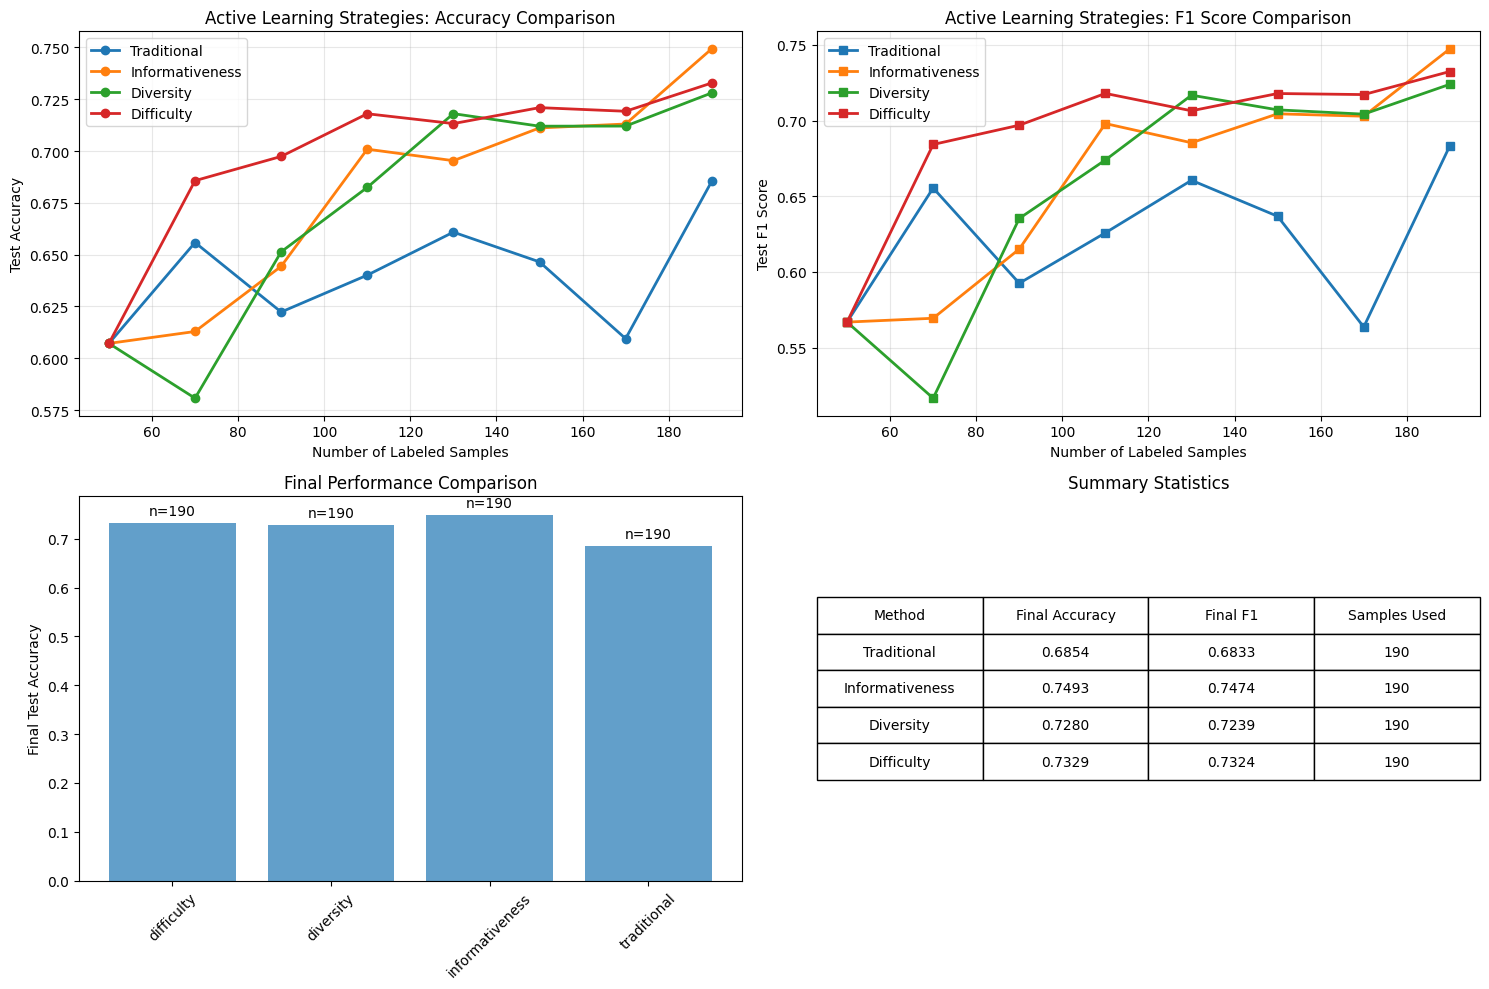

In [10]:
print("\\nExperiment Results:")
print(comparison_results.head(10))

# Plot comparison
plt.figure(figsize=(15, 10))

# Accuracy comparison
plt.subplot(2, 2, 1)
for method in comparison_results['method'].unique():
    method_data = comparison_results[comparison_results['method'] == method]
    plt.plot(method_data['labeled_size'], method_data['accuracy'], 
             marker='o', linewidth=2, label=method.title())

plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test Accuracy')
plt.title('Active Learning Strategies: Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# F1 Score comparison
plt.subplot(2, 2, 2)
for method in comparison_results['method'].unique():
    method_data = comparison_results[comparison_results['method'] == method]
    plt.plot(method_data['labeled_size'], method_data['f1_score'], 
             marker='s', linewidth=2, label=method.title())

plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test F1 Score')
plt.title('Active Learning Strategies: F1 Score Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Sample efficiency analysis
plt.subplot(2, 2, 3)
final_results = comparison_results.groupby('method').last()
methods = final_results.index
accuracies = final_results['accuracy']
sample_counts = final_results['labeled_size']

bars = plt.bar(methods, accuracies, alpha=0.7)
plt.ylabel('Final Test Accuracy')
plt.title('Final Performance Comparison')
plt.xticks(rotation=45)

# Add sample count annotations
for bar, count in zip(bars, sample_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'n={count}', ha='center', va='bottom')

# Method comparison table
plt.subplot(2, 2, 4)
plt.axis('off')
summary_data = []
for method in comparison_results['method'].unique():
    method_data = comparison_results[comparison_results['method'] == method]
    final_acc = method_data['accuracy'].iloc[-1]
    final_f1 = method_data['f1_score'].iloc[-1]
    final_samples = method_data['labeled_size'].iloc[-1]
    summary_data.append([method.title(), f"{final_acc:.4f}", f"{final_f1:.4f}", final_samples])

table = plt.table(cellText=summary_data,
                 colLabels=['Method', 'Final Accuracy', 'Final F1', 'Samples Used'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('Summary Statistics')

plt.tight_layout()
plt.show()

### 7. DETAILED ANALYSIS

In [11]:
print("\\n" + "="*60)
print("DETAILED ANALYSIS")
print("="*60)

# Sample efficiency analysis
print("\\nSample Efficiency Analysis:")
print("-" * 30)
for method in comparison_results['method'].unique():
    method_data = comparison_results[comparison_results['method'] == method]
    final_accuracy = method_data['accuracy'].iloc[-1]
    samples_used = method_data['labeled_size'].iloc[-1]
    print(f"{method.title():15s}: {final_accuracy:.4f} accuracy with {samples_used} samples")

# Learning curve steepness
print("\\nLearning Curve Analysis:")
print("-" * 25)
for method in comparison_results['method'].unique():
    method_data = comparison_results[comparison_results['method'] == method]
    initial_acc = method_data['accuracy'].iloc[0]
    final_acc = method_data['accuracy'].iloc[-1]
    improvement = final_acc - initial_acc
    print(f"{method.title():15s}: {improvement:.4f} improvement ({initial_acc:.4f} → {final_acc:.4f})")

# Statistical significance (simple comparison)
print("\\nMethod Rankings by Final Performance:")
print("-" * 35)
final_perf = comparison_results.groupby('method')['accuracy'].last().sort_values(ascending=False)
for i, (method, acc) in enumerate(final_perf.items()):
    print(f"{i+1}. {method.title():15s}: {acc:.4f}")

\n============================================================
DETAILED ANALYSIS
\nSample Efficiency Analysis:
------------------------------
Traditional    : 0.6854 accuracy with 190 samples
Informativeness: 0.7493 accuracy with 190 samples
Diversity      : 0.7280 accuracy with 190 samples
Difficulty     : 0.7329 accuracy with 190 samples
\nLearning Curve Analysis:
-------------------------
Traditional    : 0.0783 improvement (0.6071 → 0.6854)
Informativeness: 0.1422 improvement (0.6071 → 0.7493)
Diversity      : 0.1209 improvement (0.6071 → 0.7280)
Difficulty     : 0.1257 improvement (0.6071 → 0.7329)
\nMethod Rankings by Final Performance:
-----------------------------------
1. Informativeness: 0.7493
2. Difficulty     : 0.7329
3. Diversity      : 0.7280
4. Traditional    : 0.6854


### 8. QUALITATIVE ANALYSIS OF LLM SELECTIONS

In [12]:
def analyze_llm_selections(texts, labels, difficulty_levels):
    """
    Analyze what types of samples the LLM tends to select
    """
    if llm_model is None:
        print("LLM model not available for qualitative analysis")
        return
    
    print("\\n" + "="*60)
    print("QUALITATIVE ANALYSIS OF LLM SELECTIONS")
    print("="*60)
    
    llm_selector = LLMQuerySelector(llm_tokenizer, llm_model, device)
    
    # Sample a subset for analysis
    sample_indices = random.sample(range(len(texts)), 100)
    sample_texts = [texts[i] for i in sample_indices]
    sample_labels = [labels[i] for i in sample_indices]
    sample_difficulties = [difficulty_levels[i] for i in sample_indices]
    
    strategies = ['informativeness', 'diversity', 'difficulty']
    
    for strategy in strategies:
        print(f"\\n--- {strategy.upper()} STRATEGY ---")
        
        selected_indices = llm_selector.select_informative_samples(
            sample_texts, n_select=10, strategy=strategy
        )
        
        selected_texts = [sample_texts[i] for i in selected_indices]
        selected_labels = [sample_labels[i] for i in selected_indices]
        selected_difficulties = [sample_difficulties[i] for i in selected_indices]
        
        # Analyze selections
        label_dist = pd.Series(selected_labels).value_counts()
        difficulty_dist = pd.Series(selected_difficulties).value_counts()
        
        print(f"Label distribution: {label_dist.to_dict()}")
        print(f"Difficulty distribution: {difficulty_dist.to_dict()}")
        
        print("\\nSelected samples:")
        for i, (text, label, diff) in enumerate(zip(selected_texts[:3], selected_labels[:3], selected_difficulties[:3])):
            print(f"{i+1}. [{label}|{diff}] {text[:80]}...")

# Run qualitative analysis
analyze_llm_selections(texts, labels, difficulty)

\n============================================================
QUALITATIVE ANALYSIS OF LLM SELECTIONS
\n--- INFORMATIVENESS STRATEGY ---
Error generating response: Input length of input_ids is 2953, but `max_length` is set to 200. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.
Label distribution: {1: 6, 0: 4}
Difficulty distribution: {'medium': 9, 'hard': 1}
\nSelected samples:
1. [0|hard] A schizophrenic has escaped from a NYC mental hospital and soon teachers start g...
2. [0|medium] This is perhaps the worst attempt at a Zombie film I have ever had the misfortun...
3. [1|medium] The Maxx is a deep psychological introspective lightly camouflaged as a weird-ou...
\n--- DIVERSITY STRATEGY ---
Error generating response: Input length of input_ids is 2942, but `max_length` is set to 200. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.
Lab